# Introduction To Frame Sync

Frame Synchronization (FS) is one of the first and more important tasks of a wireless communications receiver. In this notebook I'll show you the basics with a barker sequence, and see how this fits into a neural network architecture.

For simple correlations we need no more than our trustworthy numpy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from comms import *

In [2]:
barker_seq = [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1]
len(barker_seq)

13

In [3]:
bpsk_scheme = [-1+0j, 1+0j]

In [4]:
preamble = np.array([bpsk_scheme[i] for i in barker_seq])

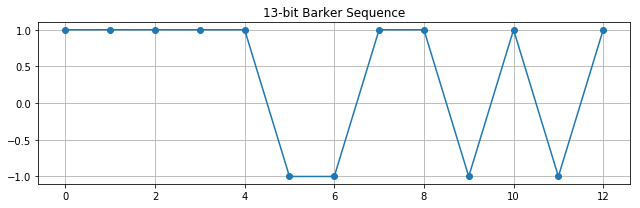

In [5]:
plt.figure(figsize=(9,3))
plt.plot(preamble.real, '-o')
plt.title('13-bit Barker Sequence')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/barker_seq.svg')

The barker sequence has a very useful property that you want in a preamble in that once you correlate it with itself, you will get a maximum response at the time instant when they fully overlap, and a much smaller response everywhere else.

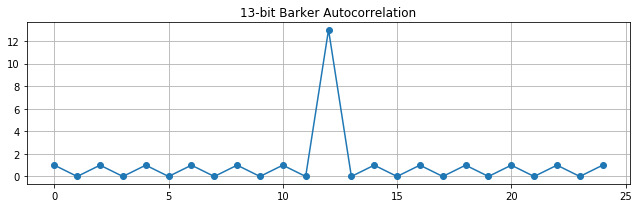

In [6]:
self_correlation = np.abs(np.correlate(preamble, preamble, mode='full'))

plt.figure(figsize=(9,3))
plt.plot(self_correlation, '-o')
plt.title('13-bit Barker Autocorrelation')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/barker_autocorr.png')

## Bursty Communication

Data being sent out in bursts can often be seen in Internet of Things (IoT) or wireless sensor networks. The task of the receiver is to sift through the static and make sure we do not lose any packets (this can get pretty difficult if interference/noise is high).

Let's create a waveform that contains a packet (preamble+payload) and some empty space. We will create a synthetic capture of 150 samples, with a packet containing a payload of 64 bits and our 13-bit barker sequence.

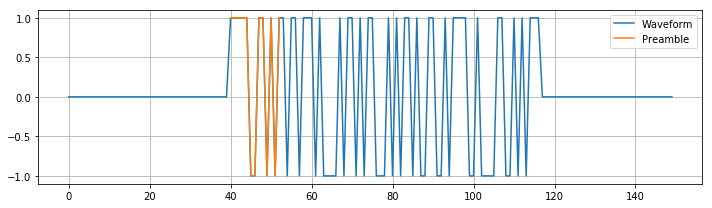

In [7]:
signal_length = 150 # total capture length
payload = 64 # payload in number of bits
tau = 40 # time offset i.e. where our packet begins in the capture

# Create empty waveform
waveform = np.zeros((signal_length,), dtype=np.complex128)

# Generate a random bit pattern packet and attach the preamble
packet = np.concatenate((barker_seq, np.random.randint(0,2,payload)))

# Map the bits of our packet to BPSK symbols
packet = np.array([bpsk_scheme[i] for i in packet])

# Insert the packet at offset tau of the waveform
waveform[tau:tau+len(packet)] = packet

# Visualization
plt.figure(figsize=(10,3))
plt.plot(waveform.real)
plt.plot(np.arange(13)+40, preamble.real)
plt.legend(('Waveform', 'Preamble'))
plt.grid()
plt.tight_layout()
plt.savefig('figures/waveform_example.png')

Our task is to recover the starting index tau. We can do this by correlating the entire waveform with our known preamble sequence, and as we know from our barker sequence autocorrelation property, we should see a big spike where they overlap perfectly -- this will be our starting index position.

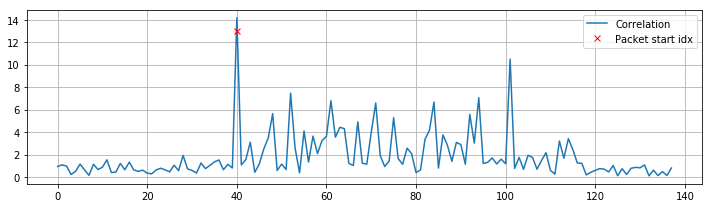

In [8]:
plt.figure(figsize=(10,3))
correlation = np.abs(np.correlate(awgn(waveform, 15), preamble, mode='valid'))
plt.plot(correlation)
plt.grid()
plt.plot(np.argmax(correlation), 13, 'rx')
plt.legend(('Correlation', 'Packet start idx'))
plt.tight_layout()
plt.savefig('figures/correlation_example.png')

We can see that the maximum argument of our correlation is 40

In [9]:
np.argmax(correlation)

40

Which is the same as tau we set previously

In [10]:
np.argmax(correlation) == tau

True

## Continuous Data Stream

It is also very common to see a continuous data stream with preambles interleaved in between the data. The job of the receiver will be the same -- detecting the packet start indexes. While this is a common communication protocol, we will mostly focus on bursty communications as seen in IoT or sensors networks.

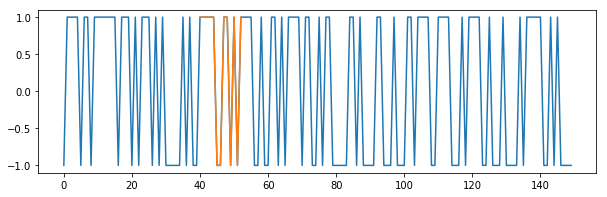

In [11]:
signal_length = 150 # total capture length
payload = 64 # payload in number of bits
tau = 40 # time offset i.e. where our packet begins in the capture

# Create random binary stream
waveform = np.random.randint(0,2,signal_length)

# Generate a random bit pattern packet and attach the preamble
packet = np.concatenate((barker_seq, np.random.randint(0,2,payload)))

# Insert the packet at offset tau of the waveform
waveform[tau:tau+len(packet)] = packet

# Map bits to BPSK symbols
waveform = np.array([bpsk_scheme[i] for i in waveform])

# Visualization
plt.figure(figsize=(10,3))
plt.plot(waveform.real)
plt.plot(np.arange(13)+40, preamble.real)
# plt.savefig('figures/cont_waveform_example.svg')

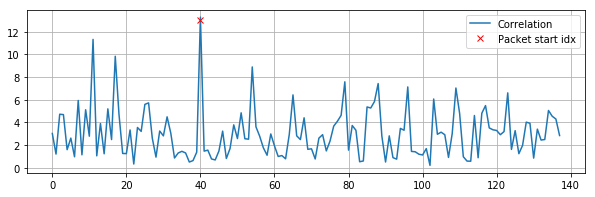

In [13]:
plt.figure(figsize=(10,3))
correlation = np.abs(np.correlate(awgn(waveform,15), preamble, mode='valid'))
plt.plot(correlation)
plt.grid()
plt.plot(np.argmax(correlation), 13, 'rx')
plt.legend(('Correlation', 'Packet start idx'))

## Implementing Preamble Detection in a Conv Layer

Create a simple neural network with the same number of weights as our barker sequence and populate it with our preamble. The 2nd layer will just add the I and Q channels together. Without any training we expect this network to perform exactly like a barker sequence correlator.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class preamble_detector(nn.Module):
    def __init__(self):
        super(preamble_detector, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 1, (1,13), 1, bias=False)
        self.conv2 = nn.Conv2d(1, 1, (2,1),1, bias=False)
    
        # initialize weights to barker
        with torch.no_grad():
            self.conv1.weight[0][0][0] = torch.tensor(preamble.real)
            self.conv2.weight[0][0] = torch.tensor(np.array([[1],[1]]))

    def forward(self, x):

        # Do cross correlation
        x = self.conv1(x)
        
        # Sum real and imag
        x = self.conv2(x)
        
        # Output only 1 dimension
        x = torch.abs(x).squeeze()

        return x
    
# Create an instance of our neural network
detector = preamble_detector()

Now because we are dealing with pytorch conv layers, we need to do some preprocessing on our waveform so that it can actually be fed into the model. Conv2d layers require a 4D input **N x Cin x H x W**, where **N** is the number of waveforms, **Cin** is the number of input channels, **H** and **W** are the height and width of our input respectively. In our case we treat the I/Q dimension as a height dimension and leave the number of channels at 1.

In [14]:
waveform = awgn(waveform, 15)
new_frame = np.expand_dims(np.vstack((waveform.real, waveform.imag)),axis=(0,1))
new_frame = torch.tensor(new_frame).float()
new_frame.shape

torch.Size([1, 1, 2, 150])

In [15]:
nn_output = detector(new_frame)

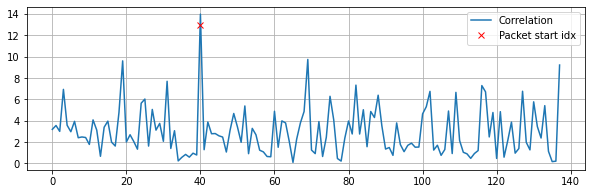

In [16]:
plt.figure(figsize=(10,3))
plt.plot(nn_output.detach().numpy().T)
plt.grid()
plt.plot(np.argmax(nn_output.detach().numpy().T), 13, 'rx')
plt.legend(('Correlation', 'Packet start idx'))

Do the same check to make sure we found the correct tau.

In [17]:
torch.argmax(nn_output) == tau

tensor(True)

So, we can hard code a neural network to do the same job as a preamble correlation. Now could we train it to do the same thing with random weights?

## Training Correlation

Create a new network, but without initializing it with the barker sequence weights.

In [18]:
class preamble_detector(nn.Module):
    def __init__(self):
        super(preamble_detector, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 1, (1,13), 1, bias=False)
        self.conv2 = nn.Conv2d(1, 1, (2,1),1, bias=False)
    
        # initialize weights to barker
#         with torch.no_grad():
#             self.conv1.weight[0][0][0] = torch.tensor(preamble.real)
#             self.conv2.weight[0][0] = torch.tensor(np.array([[1],[1]]))

    def forward(self, x):

        # Do cross correlation
        x = self.conv1(x)
        
        # Sum real and imag
        x = self.conv2(x)
        
        # Output only 1 dimension
        x = torch.abs(x).squeeze()

        return x
    
detector = preamble_detector()

We can confirm that the weights are completely random.

Parameter containing:
tensor([[[[ 0.2330, -0.1851,  0.1394, -0.1245, -0.2367,  0.2510,  0.1448,
           -0.1817, -0.0280,  0.1004,  0.2380, -0.1265, -0.0966]]]],
       requires_grad=True)

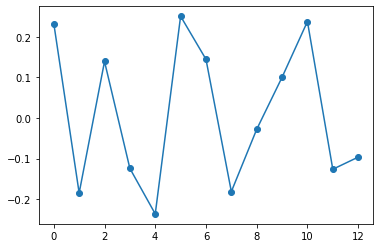

In [19]:
weights = detector.conv1.weight

plt.plot(weights.squeeze().detach().numpy(), '-o')
weights

These random weights clearly don't provide us with the correct tau.

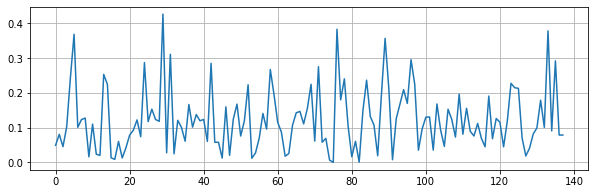

In [20]:
nn_output = detector(new_frame)

plt.figure(figsize=(10,3))
plt.plot(nn_output.detach().numpy().T)
plt.grid()

Generate some training data.

In [21]:
num_examples = 100
payload=128
signal_length=200

# Pre-define array to contain complex-valued waveforms
waveforms = np.zeros((num_examples,200),dtype=np.complex128)

# Predefine labels array
labels = np.zeros((num_examples,188)) # 200-13+1

# Generate random payload bits
bits = np.random.randint(0,2,(num_examples,payload))

# Add preambles to payloads
packet = np.concatenate((np.tile(barker_seq,(num_examples,1)), bits), axis=1)

# Map to BPSK symbols
packet = np.where(packet < 1, -1+0j, 1+0j)

# Insert into random offset and save offset as label
for idx, waveform in enumerate(waveforms):
    offset = np.random.randint(20,60)
    waveform[offset:offset+payload+len(preamble)] = packet[idx]
    waveforms[idx] = waveform
    labels[idx, offset] = 1    

# Convert labels to pytorch tensors
labels = torch.FloatTensor(labels)
    
# Split into real and imaginary channels
train_data = torch.FloatTensor(np.stack((waveforms.real, waveforms.imag),axis=1)).unsqueeze(1)#.float()
train_data.shape

torch.Size([100, 1, 2, 200])

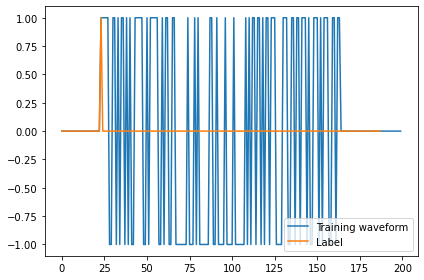

In [22]:
plt.plot(waveforms[5].real)
plt.plot(labels[5])
plt.legend(('Training waveform', 'Label'))
plt.tight_layout()

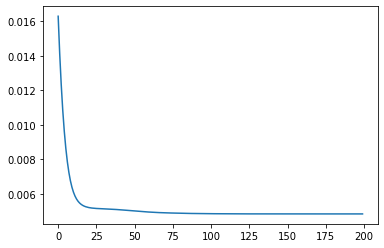

In [23]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(detector.parameters(), lr=0.01, weight_decay=0.0001)

losses = []

for epoch in range(200):  # loop over the dataset multiple times
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = detector(train_data)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
plt.plot(losses)

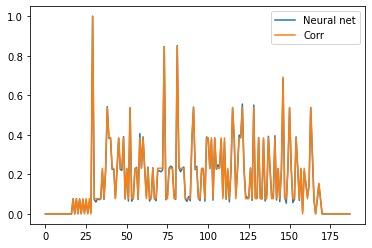

In [24]:
idx = 3

y = detector(train_data).detach().numpy()[3]
correlation = np.abs(np.correlate(waveforms[3], preamble, mode='valid'))
plt.plot(y/np.max(y))
plt.plot(correlation/np.max(correlation))
plt.legend(('Neural net', 'Corr'))

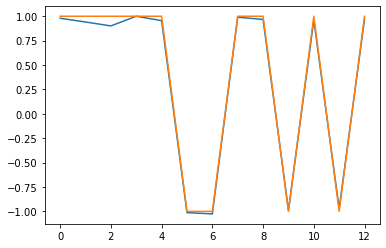

In [25]:
weights = -detector.conv1.weight.detach().numpy().squeeze().T
plt.plot(weights/np.max(weights))
plt.plot(preamble.real)